Episode 0, Step 1: Action = 4, Reward = -17.07001015998424
Episode 0, Step 2: Action = 5, Reward = -14.488274103689545
Episode 0, Step 3: Action = 3, Reward = -2.608906373177116
Episode 0, Step 4: Action = 2, Reward = -9.013922552483306
Episode 0, Step 5: Action = 1, Reward = -27.974920682186408
Episode 0, Step 6: Action = 0, Reward = -29.606266100839427
Episode 0 : Total Reward = -100.76229997236004
Episode 1, Step 1: Action = 5, Reward = -7.5103806806301625
Episode 1, Step 2: Action = 4, Reward = -14.488274103689545
Episode 1, Step 3: Action = 2, Reward = -24.47304590165611
Episode 1, Step 4: Action = 3, Reward = -9.013922552483306
Episode 1, Step 5: Action = 1, Reward = -21.059833927165815
Episode 1, Step 6: Action = 0, Reward = -29.606266100839427
Episode 1 : Total Reward = -106.15172326646436
Episode 2, Step 1: Action = 3, Reward = -8.817182343259507
Episode 2, Step 2: Action = 2, Reward = -9.013922552483306
Episode 2, Step 3: Action = 4, Reward = -24.47304590165611
Episode 2, Ste

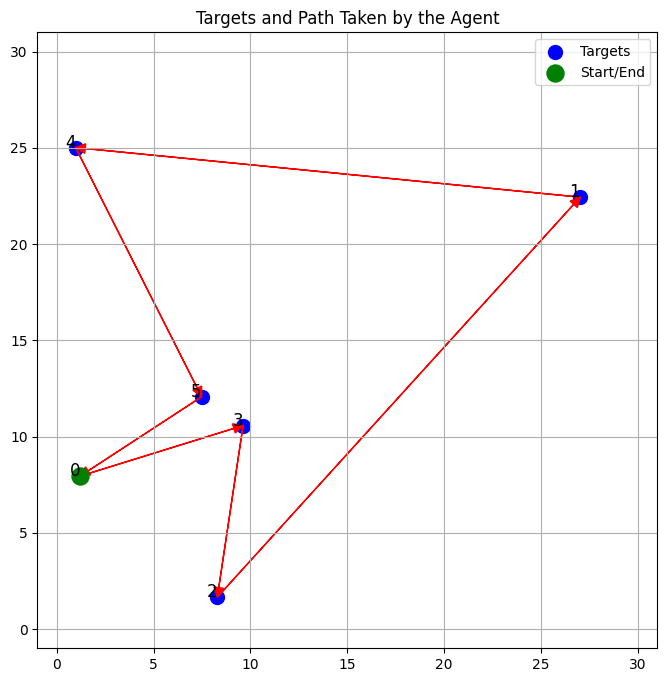

In [9]:
!pip install gymnasium
"""Environment for Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np


class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets in the least number of steps, with rewards determined by the distance traveled.
    """

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max Square area where the targets are defined. Defaults to 30
            seed (int, optional): Random seed for reproducibility. Defaults to None.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)
        self.visited_targets = []

        # Observation Space : {current loc (loc), dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0

        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(
        self, action: int
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        points = []
        # Generate n random 2D points within the 10x10 grid
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations.

        Args:
            locations (List): List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            past_loc (int): Previous location of the agent.
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000
        return reward


import matplotlib.pyplot as plt

if __name__ == "__main__":
    num_targets = 6

    env = TSP(num_targets)
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs, _ = env.reset()
        visited = [False] * num_targets
        visited[0] = True
        steps = 0
        env.loc = 0
        first_action = None

        while steps < num_targets:
            available_actions = [
                i for i in range(num_targets) if not visited[i]
            ]

            if available_actions:
                action = np.random.choice(available_actions)
                if first_action is None:
                    first_action = action
            else:
                action = 0

            obs_, reward, terminated, truncated, info = env.step(action)
            visited[action] = True
            ret += reward
            steps += 1

            print(f"Episode {ep}, Step {steps}: Action = {action}, Reward = {reward}")

            if terminated or truncated:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : Total Reward = {ret}")

    print("Average Reward over 100 episodes:", np.mean(ep_rets))

    visited_targets = env.visited_targets
    locations = env.locations

    plt.figure(figsize=(8, 8))
    plt.scatter(locations[:, 0], locations[:, 1], c='blue', label='Targets', s=100)

    for i in range(num_targets):
        plt.text(locations[i][0], locations[i][1], str(i), fontsize=12, ha='right')

    if first_action is not None:
        plt.arrow(
            locations[0][0], locations[0][1],
            locations[first_action][0] - locations[0][0],
            locations[first_action][1] - locations[0][1],
            head_width=0.5, head_length=0.5, fc='red', ec='red',
            length_includes_head=True
        )

    for i in range(len(visited_targets) - 1):
        start_idx = visited_targets[i]
        end_idx = visited_targets[i + 1]
        plt.arrow(
            locations[start_idx][0], locations[start_idx][1],
            locations[end_idx][0] - locations[start_idx][0],
            locations[end_idx][1] - locations[start_idx][1],
            head_width=0.5, head_length=0.5, fc='red', ec='red',
            length_includes_head=True
        )

    plt.scatter(locations[0][0], locations[0][1], c='green', label='Start/End', s=150)

    plt.title("Targets and Path Taken by the Agent")
    plt.legend()
    plt.grid(True)
    plt.xlim(-1, env.max_area + 1)
    plt.ylim(-1, env.max_area + 1)
    plt.show()

In [13]:
import gymnasium as gym
import numpy as np
from itertools import permutations


class TSP(gym.Env):
    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        self.steps: int = 0
        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -1000000000
        return reward


def policy_iteration(env: TSP, gamma=1, theta=1e-6, max_iterations=1000):
    num_targets = env.num_targets

    def state_to_index(state):
        """Helper function to convert state (location, visited targets) into a unique index"""
        loc, visited = state
        return loc, tuple(sorted(visited))  # Convert visited to a tuple for immutability

    def get_all_states():
        """Generates all possible states (combinations of visited targets)"""
        states = []
        for visited in range(1 << num_targets):
            visited_list = [i for i in range(num_targets) if visited & (1 << i)]
            for loc in range(num_targets):
                states.append((loc, tuple(visited_list)))  # Convert visited_list to tuple
        return states

    policy = {}
    V = {}

    all_states = get_all_states()
    for state in all_states:
        loc, visited = state
        V[state] = 0

        if len(visited) == num_targets:
            policy[state] = 0  # Go back to start
        else:
            available_actions = [i for i in range(num_targets) if i not in visited]
            if available_actions:
                policy[state] = np.random.choice(available_actions)
            else:
                policy[state] = 0
    for i in range(max_iterations):
        # Policy Evaluation
        while True:
            delta = 0
            for state in all_states:
                old_value = V[state]
                loc, visited = state

                if len(visited) == num_targets:  # All cities visited, return to start
                    V[state] = -env.distances[loc][0]
                else:
                    action = policy[state]
                    reward = -env.distances[loc][action]

                    if action in visited:
                        continue

                    next_visited = list(visited) + [action]
                    next_state = (action, tuple(sorted(next_visited)))

                    if next_state not in V:
                        V[next_state] = 0

                    V[state] = reward + gamma * V[next_state]

                delta = max(delta, abs(old_value - V[state]))
            if delta < theta:
                break

        policy_stable = True
        for state in all_states:
            loc, visited = state
            if len(visited) == num_targets:
                continue

            old_action = policy[state]
            action_values = []
            for action in range(num_targets):
                if action not in visited:
                    reward = -env.distances[loc][action]
                    next_visited = list(visited) + [action]
                    next_state = (action, tuple(sorted(next_visited)))

                    if next_state not in V:
                        V[next_state] = 0

                    action_values.append(reward + gamma * V[next_state])

            if action_values:
                best_action = np.argmax(action_values)
                policy[state] = best_action

            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break

    return policy, V


if __name__ == "__main__":
    num_targets = 6
    env = TSP(num_targets)

    optimal_policy, optimal_values = policy_iteration(env)

    print("Optimal Policy:", optimal_policy)
    print("Optimal Values:", optimal_values)




Optimal Policy: {(0, ()): 5, (1, ()): 5, (2, ()): 5, (3, ()): 5, (4, ()): 5, (5, ()): 5, (0, (0,)): 0, (1, (0,)): 0, (2, (0,)): 1, (3, (0,)): 2, (4, (0,)): 0, (5, (0,)): 4, (0, (1,)): 0, (1, (1,)): 3, (2, (1,)): 1, (3, (1,)): 1, (4, (1,)): 3, (5, (1,)): 1, (0, (0, 1)): 0, (1, (0, 1)): 0, (2, (0, 1)): 0, (3, (0, 1)): 1, (4, (0, 1)): 2, (5, (0, 1)): 0, (0, (2,)): 0, (1, (2,)): 1, (2, (2,)): 1, (3, (2,)): 2, (4, (2,)): 3, (5, (2,)): 1, (0, (0, 2)): 2, (1, (0, 2)): 0, (2, (0, 2)): 1, (3, (0, 2)): 1, (4, (0, 2)): 2, (5, (0, 2)): 1, (0, (1, 2)): 0, (1, (1, 2)): 1, (2, (1, 2)): 1, (3, (1, 2)): 1, (4, (1, 2)): 2, (5, (1, 2)): 3, (0, (0, 1, 2)): 1, (1, (0, 1, 2)): 0, (2, (0, 1, 2)): 0, (3, (0, 1, 2)): 0, (4, (0, 1, 2)): 1, (5, (0, 1, 2)): 2, (0, (3,)): 4, (1, (3,)): 4, (2, (3,)): 4, (3, (3,)): 4, (4, (3,)): 4, (5, (3,)): 4, (0, (0, 3)): 0, (1, (0, 3)): 0, (2, (0, 3)): 1, (3, (0, 3)): 0, (4, (0, 3)): 0, (5, (0, 3)): 3, (0, (1, 3)): 0, (1, (1, 3)): 2, (2, (1, 3)): 1, (3, (1, 3)): 3, (4, (1, 3)): 

In [14]:
def trace_optimal_path(start_state, optimal_policy):
    current_state = start_state
    visited_nodes = []
    path = []

    while True:
        visited_nodes.append(current_state[0])
        next_node = optimal_policy[current_state]
        path.append((current_state[0], next_node))
        current_state = (next_node, tuple(sorted(visited_nodes)))
        if next_node == 0:
            break

    return path

start_state = (0, ())
path = trace_optimal_path(start_state, optimal_policy)
print(path)


[(0, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]


In [16]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

class TSP(gym.Env):
    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        self.steps: int = 0
        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -1000000000
        return reward


def monte_carlo_tsp(env: TSP, episodes: int = 10000, gamma: float = 1.0, epsilon: float = 0.1):
    num_targets = env.num_targets

    V = defaultdict(float)
    returns = defaultdict(list)
    policy = {}

    def get_action(state, epsilon):
        """Epsilon-greedy action selection"""
        if np.random.random() < epsilon:
            available_actions = [i for i in range(num_targets) if i not in state[1]]
            return np.random.choice(available_actions)
        else:
            return policy.get(state, np.random.choice([i for i in range(num_targets) if i not in state[1]]))

    for episode in range(episodes):
        state, _ = env.reset()
        state = (int(state[0]), tuple())

        episode_data = []
        for t in range(num_targets):
            action = get_action(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = (int(next_state[0]), tuple(env.visited_targets))

            episode_data.append((state, action, reward))
            state = next_state

            if done or truncated:
                break

        G = 0
        for step in reversed(episode_data):
            state, action, reward = step
            G = reward + gamma * G
            returns[(state, action)].append(G)
            V[(state, action)] = np.mean(returns[(state, action)])

        for step in episode_data:
            state, action, _ = step
            best_action = max(range(num_targets), key=lambda a: V[(state, a)] if a not in state[1] else -float('inf'))
            policy[state] = best_action

    return policy, V


if __name__ == "__main__":
    num_targets = 10
    env = TSP(num_targets)

    optimal_policy, optimal_values = monte_carlo_tsp(env)

    print("Optimal Policy:", optimal_policy)
    print("Optimal Values:", optimal_values)


Optimal Policy: {(0, ()): 3, (1, (1,)): 0, (5, (1, 5)): 2, (6, (1, 5, 6)): 0, (7, (1, 5, 6, 7)): 0, (9, (1, 5, 6, 7, 9)): 0, (3, (1, 5, 6, 7, 9, 3)): 2, (0, (1, 5, 6, 7, 9, 3, 0)): 2, (8, (1, 5, 6, 7, 9, 3, 0, 8)): 4, (2, (1, 5, 6, 7, 9, 3, 0, 8, 2)): 4, (0, (0,)): 1, (5, (0, 5)): 2, (9, (0, 5, 9)): 1, (2, (0, 5, 9, 2)): 3, (1, (0, 5, 9, 2, 1)): 3, (4, (0, 5, 9, 2, 1, 4)): 3, (6, (0, 5, 9, 2, 1, 4, 6)): 3, (8, (0, 5, 9, 2, 1, 4, 6, 8)): 7, (3, (0, 5, 9, 2, 1, 4, 6, 8, 3)): 7, (2, (2,)): 9, (8, (2, 8)): 0, (1, (2, 8, 1)): 3, (0, (2, 8, 1, 0)): 3, (7, (2, 8, 1, 0, 7)): 3, (6, (2, 8, 1, 0, 7, 6)): 3, (5, (2, 8, 1, 0, 7, 6, 5)): 3, (9, (2, 8, 1, 0, 7, 6, 5, 9)): 3, (4, (2, 8, 1, 0, 7, 6, 5, 9, 4)): 3, (3, (3,)): 1, (6, (3, 6)): 1, (4, (3, 6, 4)): 7, (1, (3, 6, 4, 1)): 0, (2, (3, 6, 4, 1, 2)): 5, (0, (3, 6, 4, 1, 2, 0)): 5, (8, (3, 6, 4, 1, 2, 0, 8)): 5, (7, (3, 6, 4, 1, 2, 0, 8, 7)): 9, (5, (3, 6, 4, 1, 2, 0, 8, 7, 5)): 9, (4, (4,)): 5, (1, (4, 1)): 2, (0, (4, 1, 0)): 2, (3, (4, 1, 0, 3)):

In [18]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

class TSP(gym.Env):
    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        self.steps: int = 0
        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -1000000000
        return reward


def monte_carlo_tsp(env: TSP, episodes: int = 10000, gamma: float = 1.0, epsilon: float = 0.1):
    num_targets = env.num_targets

    V = defaultdict(float)
    returns = defaultdict(list)
    policy = {}

    def get_action(state, epsilon):
        """Epsilon-greedy action selection"""
        if np.random.random() < epsilon:
            available_actions = [i for i in range(num_targets) if i not in state[1]]
            return np.random.choice(available_actions)
        else:
            return policy.get(state, np.random.choice([i for i in range(num_targets) if i not in state[1]]))

    for episode in range(episodes):
        state, _ = env.reset()
        state = (int(state[0]), tuple())

        # Generate an episode
        episode_data = []
        for t in range(num_targets):
            action = get_action(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = (int(next_state[0]), tuple(env.visited_targets))

            episode_data.append((state, action, reward))
            state = next_state

            if done or truncated:
                break

        G = 0
        visited_pairs = set()
        for step in reversed(episode_data):
          state, action, reward = step
          if (state, action) not in visited_pairs:
            G = reward + gamma * G
            returns[(state, action)].append(G)
            V[(state, action)] = np.mean(returns[(state, action)])
            visited_pairs.add((state, action))

        for step in episode_data:
            state, action, _ = step
            best_action = max(range(num_targets), key=lambda a: V[(state, a)] if a not in state[1] else -float('inf'))
            policy[state] = best_action

    return policy, V


if __name__ == "__main__":
    num_targets = 6
    env = TSP(num_targets)

    optimal_policy, optimal_values = monte_carlo_tsp(env)

    print("Optimal Policy:", optimal_policy)
    print("Optimal Values:", optimal_values)

Optimal Policy: {(0, ()): 0, (5, (5,)): 0, (2, (5, 2)): 3, (0, (5, 2, 0)): 3, (1, (5, 2, 0, 1)): 3, (4, (5, 2, 0, 1, 4)): 3, (0, (0,)): 5, (2, (0, 2)): 3, (3, (0, 2, 3)): 5, (5, (0, 2, 3, 5)): 4, (4, (0, 2, 3, 5, 4)): 1, (3, (3,)): 5, (5, (3, 5)): 0, (2, (3, 5, 2)): 1, (1, (3, 5, 2, 1)): 4, (4, (3, 5, 2, 1, 4)): 0, (1, (1,)): 4, (5, (1, 5)): 3, (4, (1, 5, 4)): 0, (2, (1, 5, 4, 2)): 0, (3, (1, 5, 4, 2, 3)): 0, (2, (2,)): 1, (4, (2, 4)): 0, (3, (2, 4, 3)): 0, (1, (2, 4, 3, 1)): 5, (0, (2, 4, 3, 1, 0)): 5, (4, (4,)): 1, (3, (4, 3)): 5, (0, (4, 3, 0)): 1, (2, (4, 3, 0, 2)): 1, (5, (4, 3, 0, 2, 5)): 1, (1, (0, 1)): 2, (3, (0, 1, 3)): 5, (4, (0, 1, 3, 4)): 2, (5, (0, 1, 3, 4, 5)): 2, (0, (3, 0)): 5, (4, (3, 0, 4)): 2, (1, (3, 0, 4, 1)): 2, (5, (3, 0, 4, 1, 5)): 2, (1, (3, 1)): 4, (5, (3, 1, 5)): 2, (0, (3, 1, 5, 0)): 2, (4, (3, 1, 5, 0, 4)): 2, (2, (3, 2)): 5, (1, (3, 2, 1)): 4, (5, (3, 2, 1, 5)): 4, (0, (3, 2, 1, 5, 0)): 4, (4, (3, 4)): 2, (5, (3, 4, 5)): 0, (2, (3, 4, 5, 2)): 1, (0, (3, 4,